# Vanilla GAN —— Non-Saturating GAN
NSGAN指的是通过 $-\log(D(x))$，即直接反转正负样本方式的GAN

### Trick
 - Soft label
# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image 

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline
from itertools import product # draw 10 * 10 images

from tqdm import tqdm

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
batch_size = 128
num_epoch = 200
z_dimension = 100 # size of input noise
lr_G = 1e-4
lr_D = 1e-4 # leanring rate of Generator and Discriminator
softlabel = 0.1 # 不要超过0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])
    
# MNIST datasets downloading……
mnist = datasets.MNIST(
    root = '../../data/mnist/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = mnist, batch_size = batch_size, shuffle = True
)


In [4]:
def to_gray_img(x):
    out = 0.5*(x+1)
    out = out.clamp(0,1) # force therandom distribution of x into [min, max]
    out = out.view(-1, 1, 28, 28) # view a multi-row Tensor as one row
    return out

# Discriminator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the input size of our fully connection network is 784.

It is a **unconditional** version.

In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__() # 说起来这句是干嘛的？
        self.D = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # propability of the given image being Real
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla FC Fashion)
Considering that the MNIST images are all of 28 * 28 images, the output size of our fully connection network is 784.

The final `Tanh` activataion function can project output into (-1,1)

It is a **unconditional** version.

In [6]:
class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

# Traning Phase
## Model & Opitmizer

In [7]:

D = discriminator()
G = generator()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [8]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D)
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G)

## Trainning Start!

  0%|          | 0/200 [00:00<?, ?it/s]

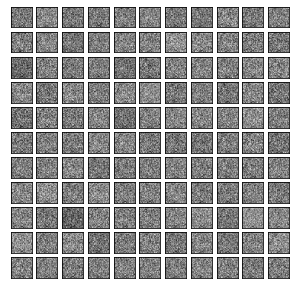

Epoch[0/200],d_loss:0.962550,g_loss:0.863483 D real: 0.828197,D fake: 0.406140
Epoch[0/200],d_loss:0.722445,g_loss:1.634959 D real: 0.889141,D fake: 0.167681
Epoch[0/200],d_loss:0.667261,g_loss:2.027217 D real: 0.886656,D fake: 0.108345
Epoch[0/200],d_loss:0.808521,g_loss:1.370858 D real: 0.806547,D fake: 0.226469


  0%|          | 1/200 [00:56<3:07:47, 56.62s/it]

Epoch[1/200],d_loss:0.705687,g_loss:2.262161 D real: 0.868535,D fake: 0.084203
Epoch[1/200],d_loss:0.686386,g_loss:1.949805 D real: 0.878098,D fake: 0.118779
Epoch[1/200],d_loss:0.741743,g_loss:1.720675 D real: 0.837103,D fake: 0.151507
Epoch[1/200],d_loss:0.807488,g_loss:1.965982 D real: 0.833848,D fake: 0.117528


  1%|          | 2/200 [01:32<2:46:10, 50.35s/it]

Epoch[2/200],d_loss:0.703301,g_loss:2.251128 D real: 0.840767,D fake: 0.084277
Epoch[2/200],d_loss:0.689155,g_loss:2.094907 D real: 0.887853,D fake: 0.099862
Epoch[2/200],d_loss:0.696990,g_loss:1.993608 D real: 0.846749,D fake: 0.112084


  1%|          | 2/200 [02:08<3:32:35, 64.42s/it]

Epoch[2/200],d_loss:0.800596,g_loss:1.551141 D real: 0.791845,D fake: 0.185324


KeyboardInterrupt: 

In [9]:
for epoch in tqdm(range(num_epoch)):
    if epoch % 10 == 0:
        G.eval()
        z = torch.randn(batch_size, z_dimension).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(img[k].data.view(28,28).cpu().numpy(), cmap='gray')
            k += 1
        plt.show()
        
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        # =============================== LABELS =================================
        real_label = (torch.ones(num_img) - softlabel).view(-1, 1).to(device) # Label of real images is 1 - softlabel
        fake_label = (torch.zeros(num_img) + softlabel).view(-1, 1).to(device) # label of real images is 0 + softlabel
        
        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img)
        d_loss_real = criterion(real_out, real_label) # TODO: criterion
        
        z = torch.randn(num_img, z_dimension).to(device)

        fake_img = G(z)
        fake_out = D(fake_img)
        d_loss_fake = criterion(fake_out, fake_label)
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img)
        g_loss = criterion(fake_out, real_label)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # ============= Visualization ===============
        if (i+1)%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = to_gray_img(real_img.cpu().data)
        save_image(real_images, '../img/real_images.png')
 
    fake_images = to_gray_img(fake_img.cpu().data)
    save_image(fake_images, '../img/fake_images-{}.png'.format(epoch+1))'''

# Debug 专区

In [ ]:
print(real_out.size())

In [ ]:
torch.save(G.state_dict(),'./generator.pth')
torch.save(D.state_dict(),'./discriminator.pth')